In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress
from itertools import cycle
from sklearn.linear_model import LinearRegression

/cvmfs/cms.cern.ch/el9_amd64_gcc12/external/py3-numpy/1.24.3-a3a65cbc18c6a98e06451d4329e3ea47/lib/python3.9/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/cvmfs/cms.cern.ch/el9_amd64_gcc12/external/py3-numpy/1.24.3-a3a65cbc18c6a98e06451d4329e3ea47/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/cvmfs/cms.cern.ch/el9_amd64_gcc12/external/py3-numpy/1.24.3-a3a65cbc18c6a98e06451d4329e3ea47/lib/python3.9/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/cvmfs/cms.cern.ch/el9_amd64_gcc12/external/py3-numpy/1.24.3-a3a65cbc18c6a98e06451d4329e3ea47/lib/python3.9/site-pac

# Fitting LUT vs Split

In [2]:

# -------------------------------------------------------------------
# 1. Load your synthesis table (should have at least: precision, LUT, splits)
# -------------------------------------------------------------------
df = pd.read_csv("/data/data.polcms/cms/debnath/HGCAL/hls/conifer_multiclass_opti_6Integer_ovoPhoton.csv")


In [3]:
df = df.dropna(subset=["precision", "LUT", "splits"])
df["precision"] = df["precision"].astype(int)

# optional: restrict to one depth, one round config if you have multiple
df = df[df["depth"] == 4]

# -------------------------------------------------------------------
# 2. Define a helper to extract linear region and fit R
# -------------------------------------------------------------------
def extract_R_linear(df_sub, min_frac=0.25, max_frac=0.75):
    """
    Fit LUT vs splits only on the middle fraction of points (to avoid early plateau & saturation).
    Returns slope (R), intercept, and relative RMS error.
    """
    if len(df_sub) < 3:
        return np.nan, np.nan, np.nan

    # sort by splits
    df_sub = df_sub.sort_values("splits")
    n = len(df_sub)
    i1, i2 = int(min_frac * n), int(max_frac * n)
    df_lin = df_sub.iloc[i1:i2] if i2 > i1 else df_sub

    x = df_lin["splits"].to_numpy()
    y = df_lin["LUT"].to_numpy()
    slope, intercept, r, p, stderr = linregress(x, y)
    pred = slope * x + intercept
    rms = np.sqrt(np.mean((y - pred) ** 2))
    rel_err = rms / np.mean(y) if np.mean(y) > 0 else np.nan
    return slope, intercept, rel_err

# -------------------------------------------------------------------
# 3. Loop over precisions and extract R
# -------------------------------------------------------------------
R_table = []

for prec in sorted(df["precision"].unique()):
    sub = df[df["precision"] == prec]
    R, intercept, rel_err = extract_R_linear(sub)
    R_table.append(dict(precision=prec, R=R, intercept=intercept, rel_err=rel_err))

R_df = pd.DataFrame(R_table)
R_df


,precision,R,intercept,rel_err
0,10,0.355000,97.000000,0.003562
1,11,0.610833,-938.833333,0.002753
2,12,0.590833,-546.500000,0.013521
3,13,0.291667,-485.000000,0.036311
4,14,1.813333,-5540.000000,0.185292
5,15,1.069167,-2126.500000,0.031407
6,16,1.225000,-2506.666667,0.018582
7,17,1.389167,-2265.833333,0.022522
8,18,1.070833,-1486.500000,0.017143
9,19,1.141667,-1577.333333,0.017288


In [4]:
# conservative fallback for 1–2 bits → reuse R from 3-bit
R3 = R_df.loc[R_df["precision"] == 3, "R"].values
if len(R3):
    fallback_R = R3[0]
    R_df.loc[R_df["precision"].isin([1,2]), "R"] = fallback_R

# classify reliability
def reliability(row):
    if row["precision"] < 3:
        return "fixed (fallback)"
    elif row["precision"] < 5:
        return "unreliable (50–100%)"
    elif row["rel_err"] > 0.1:
        return "moderate (10–50%)"
    else:
        return "reliable (≤10%)"

R_df["reliability"] = R_df.apply(reliability, axis=1)
R_df

,precision,R,intercept,rel_err,reliability
0,10,0.355000,97.000000,0.003562,reliable (≤10%)
1,11,0.610833,-938.833333,0.002753,reliable (≤10%)
2,12,0.590833,-546.500000,0.013521,reliable (≤10%)
3,13,0.291667,-485.000000,0.036311,reliable (≤10%)
4,14,1.813333,-5540.000000,0.185292,moderate (10–50%)
5,15,1.069167,-2126.500000,0.031407,reliable (≤10%)
6,16,1.225000,-2506.666667,0.018582,reliable (≤10%)
7,17,1.389167,-2265.833333,0.022522,reliable (≤10%)
8,18,1.070833,-1486.500000,0.017143,reliable (≤10%)
9,19,1.141667,-1577.333333,0.017288,reliable (≤10%)


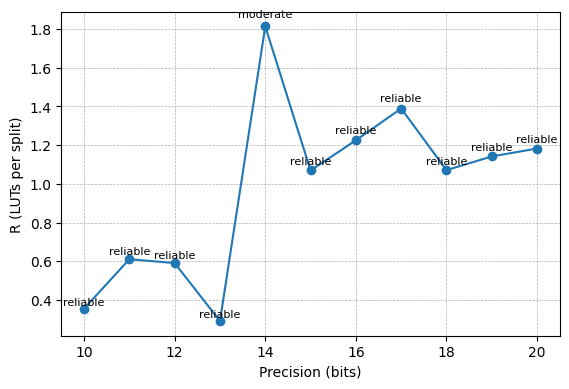

In [5]:
fig, ax = plt.subplots(figsize=(5.8,4))
ax.plot(R_df["precision"], R_df["R"], "o-", label="Extracted R")
ax.set_xlabel("Precision (bits)")
ax.set_ylabel("R (LUTs per split)")
for i, row in R_df.iterrows():
    ax.text(row["precision"], row["R"]*1.02, row["reliability"].split()[0],
            ha="center", va="bottom", fontsize=8)
ax.grid(True, ls="--", lw=0.5)
plt.tight_layout()
plt.show()


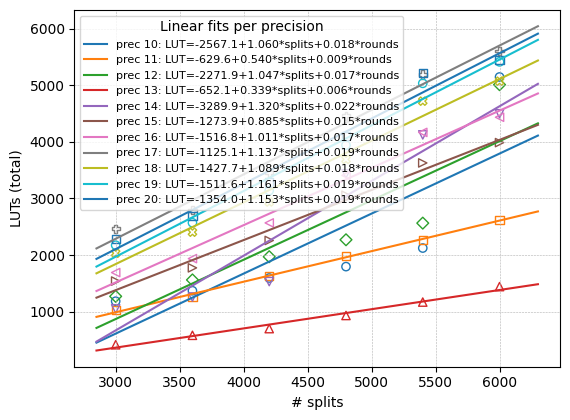

In [8]:
df = df.dropna(subset=["precision", "LUT", "splits", "rounds"])
df = df[(df["precision"] > 0) & (df["LUT"] > 0) & (df["splits"] > 0) & (df["rounds"] > 0)]
df["precision"] = df["precision"].astype(int)
df["depth"] = df["depth"].astype(int)
df["rounds"] = df["rounds"].astype(int)

fig, ax = plt.subplots(figsize=(5.8, 4.3))

# Color / marker cycles for precisions
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])
marker_cycle = cycle(["o", "s", "D", "^", "v", ">", "<", "P", "X"])

for prec in sorted(df["precision"].unique()):
    df_p = df[df["precision"] == prec]

    if len(df_p) < 3:
        continue  # not enough points for a meaningful fit

    # Regressors: splits and rounds
    X = df_p[["splits", "rounds"]].to_numpy(dtype=float)
    y = df_p["LUT"].to_numpy(dtype=float)

    # Fit model: LUT = a + b*splits + c*rounds
    reg = LinearRegression().fit(X, y)
    a = reg.intercept_
    b, c = reg.coef_

    clr = next(color_cycle)
    mkr = next(marker_cycle)

    # Scatter data points (LUT vs splits) for this precision
    ax.scatter(
        df_p["splits"], y,
        facecolors="none",
        edgecolors=clr,
        marker=mkr,
    )

    # Plot line for this precision at median(rounds)
    r_median = df_p["rounds"].median()
    xx = np.linspace(df_p["splits"].min() * 0.95,
                     df_p["splits"].max() * 1.05,
                     200)
    yy = a + b * xx + c * r_median

    ax.plot(
        xx, yy, "-", color=clr,
        label=f"prec {prec}: LUT={a:.1f}+{b:.3f}*splits+{c:.3f}*rounds"
    )

ax.set_xlabel("# splits")
ax.set_ylabel("LUTs (total)")
ax.grid(True, ls="--", lw=0.4)
ax.legend(title="Linear fits per precision", fontsize=8)
plt.tight_layout()
plt.show()

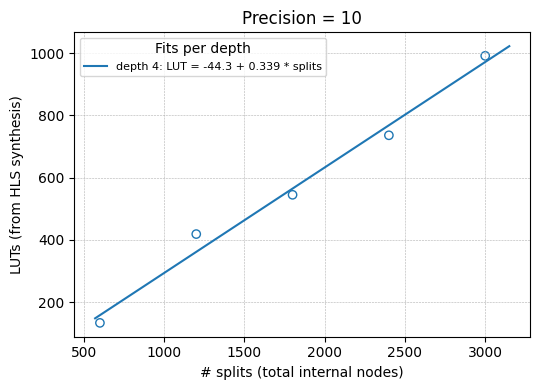

In [20]:
df = df.dropna(subset=["precision", "LUT_logic", "splits", "depth"])
df = df[(df["precision"] > 0) & (df["LUT_logic"] > 0) & (df["splits"] > 0)]
df["precision"] = df["precision"].astype(int)
df["depth"] = df["depth"].astype(int)

# Fix precision = 10
df10 = df[df["precision"] == 10].copy()
if df10.empty:
    raise ValueError("No entries with precision == 10 in the dataframe!")

fig, ax = plt.subplots(figsize=(5.5, 4))

color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])
marker_cycle = cycle(["o", "s", "D", "^", "v", ">", "<", "P", "X"])

def fmt_coeff(x):
    """Nice formatting: 3 significant figs, avoid -0.000."""
    x_ = 0.0 if abs(x) < 1e-6 else x
    return f"{x_:.3g}"

for depth in sorted(df10["depth"].unique()):
    df_d = df10[df10["depth"] == depth]

    x = df_d["splits"].to_numpy(dtype=float)
    y = df_d["LUT_logic"].to_numpy(dtype=float)

    if len(x) == 0:
        continue

    c = next(color_cycle)
    m = next(marker_cycle)

    # Scatter data (unlabeled to keep legend from exploding)
    ax.scatter(
        x, y,
        facecolors="none",
        edgecolors=c,
        marker=m
    )

    if len(np.unique(x)) < 2:
        # Can't fit a line with a single x value
        ax.scatter([], [], facecolors="none", edgecolors=c, marker=m,
                   label=f"depth {depth}: no fit")
        continue

    # Linear fit: LUT = a + b * splits
    b, a = np.polyfit(x, y, 1)

    # Smooth line over x range
    xx = np.linspace(x.min() * 0.95, x.max() * 1.05, 200)
    yy = a + b * xx

    a_str = fmt_coeff(a)
    b_str = fmt_coeff(b)
    label = f"depth {depth}: LUT = {a_str} + {b_str} * splits"

    ax.plot(xx, yy, "-", color=c, label=label)

ax.set_xlabel("# splits (total internal nodes)")
ax.set_ylabel("LUTs (from HLS synthesis)")
ax.set_title("Precision = 10")
ax.grid(True, ls="--", lw=0.4)
ax.legend(title="Fits per depth", fontsize=8)
plt.tight_layout()
plt.show()

In [21]:
split_counts = {'cl3d_showerlength': 3000, 'cl3d_coreshowerlength': 3000, 'cl3d_firstlayer': 3000,
    'cl3d_eot': 3000, 'cl3d_firstHcal5layers': 3000,
    'cl3d_varrr': 3000, 'cl3d_varzz': 3000, 'cl3d_varee': 3000, 'cl3d_varpp': 3000,
    'cl3d_meanz': 3000, 'cl3d_first1layers': 3000, 'cl3d_first5layers': 3000,
    'cl3d_last5layers': 3000, 'cl3d_emax5layers': 3000,
    'cl3d_ebm0': 3000, 'cl3d_ebm1': 3000, 'cl3d_hbm': 3000}
nbits_dict = {
    'cl3d_showerlength': 6, 'cl3d_coreshowerlength': 6, 'cl3d_firstlayer': 6,
    'cl3d_eot': 14, 'cl3d_firstHcal5layers': 8,
    'cl3d_varrr': 7, 'cl3d_varzz': 7, 'cl3d_varee': 5, 'cl3d_varpp': 7,
    'cl3d_meanz': 12, 'cl3d_first1layers': 5, 'cl3d_first5layers': 7,
    'cl3d_last5layers': 4, 'cl3d_emax5layers': 14,
    'cl3d_ebm0': 14, 'cl3d_ebm1': 14, 'cl3d_hbm': 14
}

In [15]:
def lut_per_split_from_bits(bits, a, b):
    return max(0.0, a + b * float(bits))

feat_rows = []
total_LUT = 0.0

for feat, nsplits in split_counts.items():
    bits = nbits_dict.get(feat)
    if bits is None:
        # feature not in nbits_dict → skip or raise
        continue
    lps = lut_per_split_from_bits(bits, a, b)
    LUT_feat = nsplits * lps
    total_LUT += LUT_feat
    feat_rows.append({
        "feature": feat,
        "bits": bits,
        "splits": nsplits,
        "LUT_per_split_est": lps,
        "LUT_total_est": LUT_feat
    })

df_est = pd.DataFrame(feat_rows).sort_values("LUT_total_est", ascending=False)
total_splits = sum(split_counts.values())
R_eff = total_LUT / total_splits

print(f"Total splits = {total_splits}")
print(f"Estimated total LUTs = {total_LUT:.1f}")
print(f"Effective R (LUT/split) = {R_eff:.3f}")
df_est

Total splits = 51000
Estimated total LUTs = 12766.6
Effective R (LUT/split) = 0.250


,feature,bits,splits,LUT_per_split_est,LUT_total_est
16,cl3d_hbm,14,3000,0.531255,1593.765963
15,cl3d_ebm1,14,3000,0.531255,1593.765963
3,cl3d_eot,14,3000,0.531255,1593.765963
14,cl3d_ebm0,14,3000,0.531255,1593.765963
13,cl3d_emax5layers,14,3000,0.531255,1593.765963
9,cl3d_meanz,12,3000,0.422421,1267.261995
4,cl3d_firstHcal5layers,8,3000,0.204751,614.254058
11,cl3d_first5layers,7,3000,0.150334,451.002074
8,cl3d_varpp,7,3000,0.150334,451.002074
6,cl3d_varzz,7,3000,0.150334,451.002074


In [16]:
12767/1728000

0.007388310185185185